# NER Model Comparison on DNRTI Dataset

This notebook compares two NER models, **CyNER** and **SecureBERT**, on the **DNRTI** dataset.

## 1. Setup
Install necessary libraries and import modules.

In [13]:
!pip install transformers torch pandas scikit-learn seqeval rarfile seaborn matplotlib

  Using cached matplotlib-3.10.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-macosx_10_13_universal2.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
Using cached matplotlib-3.10.8-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp313-cp313-macosx_10_13_universal2.whl (2.8 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 23.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m7/8 [seaborn]ib]

[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run:

In [14]:
import os
import json
import shutil
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from seqeval.metrics import classification_report
import torch

# Check for GPU
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {device}")

Using device: -1


## 2. Load DNRTI Dataset
The dataset is expected to be in `DNRTI` folder as `train.txt`, `test.txt`, and `valid.txt`.

In [15]:
DATA_DIR = "../DNRTI"

def load_dnrti_file(file_path):
    data = []
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found.")
        return data
        
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        tokens = []
        labels = []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    data.append({'tokens': tokens, 'labels': labels})
                    tokens = []
                    labels = []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    # The format is typically: Token Label
                    # Sometimes there might be more columns, usually label is last
                    tokens.append(parts[0])
                    labels.append(parts[-1])
        if tokens:
             data.append({'tokens': tokens, 'labels': labels})
    return data

def load_all_dnrti_data(data_dir):
    all_data = []
    for filename in ['train.txt', 'test.txt', 'valid.txt']:
        file_path = os.path.join(data_dir, filename)
        print(f"Loading {filename}...")
        file_data = load_dnrti_file(file_path)
        print(f"  Loaded {len(file_data)} sentences from {filename}")
        all_data.extend(file_data)
    return all_data

# Load all data
data = load_all_dnrti_data(DATA_DIR)
print(f"Total sentences loaded: {len(data)}")

Loading train.txt...
  Loaded 5251 sentences from train.txt
Loading test.txt...
  Loaded 664 sentences from test.txt
Loading valid.txt...
  Loaded 662 sentences from valid.txt
Total sentences loaded: 6577


### Check all unique labels in DNTRI Dataset

In [21]:
from collections import Counter

all_labels = set()
label_counts = Counter()

for d in data:
    for label in d['labels']:
        all_labels.add(label)
        label_counts[label] += 1

# Separate entity types (strip B-/I- prefix) from the full BIO tags
entity_types = set()
for label in all_labels:
    if label.startswith("B-") or label.startswith("I-"):
        entity_types.add(label[2:])

print(f"Total unique BIO tags: {len(all_labels)}")
print(f"Unique entity types (excluding O): {len(entity_types)}\n")

print("--- All BIO tags ---")
for label in sorted(all_labels):
    print(f"  {label:20s} count: {label_counts[label]}")

print(f"\n--- Entity types ---")
for etype in sorted(entity_types):
    b_count = label_counts.get(f"B-{etype}", 0)
    i_count = label_counts.get(f"I-{etype}", 0)
    print(f"  {etype:20s} B: {b_count:>6,}   I: {i_count:>6,}   Total: {b_count + i_count:>6,}")

Total unique BIO tags: 27
Unique entity types (excluding O): 13

--- All BIO tags ---
  B-Area               count: 2531
  B-Exp                count: 1331
  B-Features           count: 1025
  B-HackOrg            count: 4214
  B-Idus               count: 1579
  B-OffAct             count: 1662
  B-Org                count: 1361
  B-Purp               count: 918
  B-SamFile            count: 1660
  B-SecTeam            count: 1327
  B-Time               count: 1678
  B-Tool               count: 3081
  B-Way                count: 1037
  I-Area               count: 916
  I-Exp                count: 628
  I-Features           count: 1416
  I-HackOrg            count: 1251
  I-Idus               count: 557
  I-OffAct             count: 1007
  I-Org                count: 1128
  I-Purp               count: 1506
  I-SamFile            count: 740
  I-SecTeam            count: 594
  I-Time               count: 981
  I-Tool               count: 1703
  I-Way                count: 981
  O         

In [ ]:
# --- DNRTI Label Distribution Visualizations ---

entity_names = sorted(entity_types)
b_counts = [label_counts.get(f"B-{e}", 0) for e in entity_names]
i_counts = [label_counts.get(f"I-{e}", 0) for e in entity_names]
total_counts = [b + i for b, i in zip(b_counts, i_counts)]

# 1. Total entity counts (horizontal bar)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = sns.color_palette("viridis", len(entity_names))
sorted_idx = np.argsort(total_counts)[::-1]
sorted_names = [entity_names[i] for i in sorted_idx]
sorted_totals = [total_counts[i] for i in sorted_idx]
sorted_colors = [colors[i] for i in sorted_idx]

axes[0].barh(sorted_names, sorted_totals, color=sorted_colors)
axes[0].set_xlabel("Token Count")
axes[0].set_title("DNRTI Entity Type Distribution (Total)")
axes[0].invert_yaxis()
for i, v in enumerate(sorted_totals):
    axes[0].text(v + 50, i, f"{v:,}", va='center', fontsize=9)

# 2. Stacked B/I breakdown
x = np.arange(len(entity_names))
width = 0.6
sorted_b = [b_counts[i] for i in sorted_idx]
sorted_i = [i_counts[i] for i in sorted_idx]

axes[1].barh(sorted_names, sorted_b, width, label='B- (Begin)', color='#2196F3')
axes[1].barh(sorted_names, sorted_i, width, left=sorted_b, label='I- (Inside)', color='#FF9800')
axes[1].set_xlabel("Token Count")
axes[1].set_title("DNRTI Entity Type: B- vs I- Breakdown")
axes[1].invert_yaxis()
axes[1].legend()

plt.tight_layout()
plt.show()

# 3. Pie chart of entity proportions (excluding O)
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    sorted_totals,
    labels=sorted_names,
    autopct='%1.1f%%',
    colors=sns.color_palette("Set3", len(sorted_names)),
    pctdistance=0.85
)
ax.set_title("DNRTI Entity Type Proportions (excluding O)")
plt.setp(autotexts, size=9)
plt.tight_layout()
plt.show()

## 3. Preprocessing and Splitting
Split dataset into Test (90%) and Validation (10%).

In [16]:
texts = [d['tokens'] for d in data]
labels = [d['labels'] for d in data]

if not texts:
    print("No data loaded. Please ensure dataset is correctly extracted in DNRTI folder.")
else:
    # Split 90% Test, 10% Validation
    train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.1, random_state=42)

    # Assign to test/val variables
    test_texts = train_texts  # 90%
    test_labels = train_labels
    # val_texts and val_labels are 10%

    print(f"Test set size (90%): {len(test_texts)}")
    print(f"Validation set size (10%): {len(val_texts)}")

Test set size (90%): 5919
Validation set size (10%): 658


## 4. Model Setup
Load **CyNER** and **SecureBERT** and save them locally.

In [17]:
MODELS = {
    "CyNER": ("AI4Sec/cyner-xlm-roberta-base", "../NER/CyNER"),
    "SecureBERT": ("CyberPeace-Institute/SecureBERT-NER", "../NER/SecureBert-NER")
}

pipelines = {}
for name, (model_id, local_path) in MODELS.items():
    print(f"Loading {name}...")
    try:
        # Check if model is already downloaded locally
        if not os.path.exists(local_path) or not os.listdir(local_path):
             print(f"Downloading {name} to {local_path}...")
             tokenizer = AutoTokenizer.from_pretrained(model_id)
             model = AutoModelForTokenClassification.from_pretrained(model_id)
             tokenizer.save_pretrained(local_path)
             model.save_pretrained(local_path)
        else:
             print(f"Loading {name} from local path {local_path}...")
        
        tokenizer = AutoTokenizer.from_pretrained(local_path)
        model = AutoModelForTokenClassification.from_pretrained(local_path)
        pipelines[name] = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=device)
    except Exception as e:
        print(f"Error loading {name}: {e}")

Loading CyNER...
Loading CyNER from local path NER/CyNER...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1182.15it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


Loading SecureBERT...
Loading SecureBERT from local path NER/SecureBert-NER...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1329.89it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


## 5. Comparison
Evaluate models on the dataset (Latency, Precision, Recall, F1).

Evaluating on 658 documents from Validation Set...

Evaluating CyNER...
  Latency: 0.0423s per doc  |  Total: 27.8s
  Precision: 0.0182
  Recall:    0.0421
  F1:        0.0255

  Per-entity breakdown:
              precision    recall  f1-score   support

        Area       0.00      0.00      0.00       270
         Exp       0.00      0.00      0.00       120
    Features       0.00      0.00      0.00        75
     HackOrg       0.00      0.00      0.00       450
        Idus       0.00      0.00      0.00       149
      OffAct       0.00      0.00      0.00       161
         Org       0.07      0.15      0.09       132
        Purp       0.00      0.00      0.00        91
     SamFile       0.00      0.00      0.00       152
     SecTeam       0.00      0.00      0.00       114
        Time       0.00      0.00      0.00       176
        Tool       0.17      0.40      0.24       308
         Way       0.00      0.00      0.00       115

   micro avg       0.13      0.06      0.

/var/folders/b2/r64p6kv15n33cd11gh4qf74m0000gn/T/ipykernel_61438/88487467.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Latency (s/doc)", data=df_results, palette="viridis")


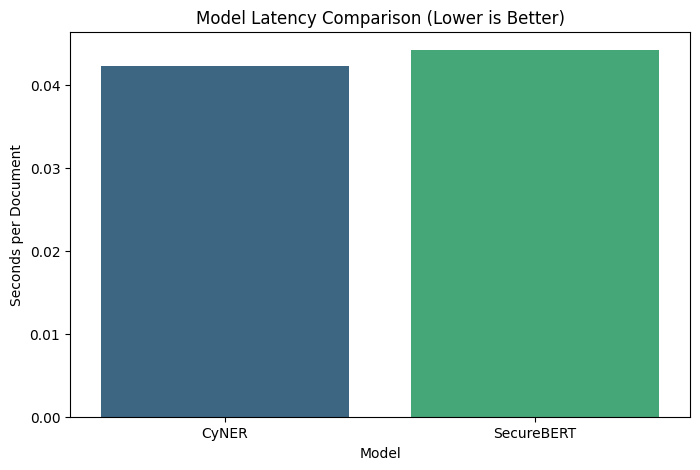

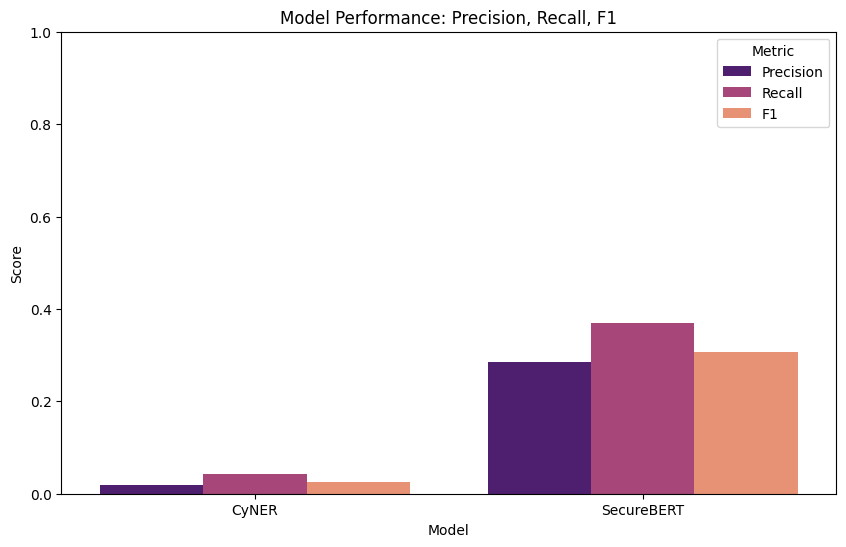

In [ ]:
# --- Configuration & Mappings ---

# Map model-predicted entity group names -> DNRTI label names
LABEL_MAP = {
    # SecureBERT mappings
    "APT": "HackOrg",
    "MAL": "Tool",
    "TOOL": "Tool",
    "LOC": "Area",
    "TIME": "Time",
    "SECTEAM": "Org",
    "IDTY": "Idus",
    "ACT": "Way",
    "VULNAME": "Way",
    "VULID": "Way",
    "OS": "Tool",
    "FILE": "Tool",
    "ENCR": "Tool",
    "PROT": "Tool",
    "DOM": "Tool",
    "URL": "Tool",
    "IP": "Tool",
    "SHA2": "Tool",
    "SHA1": "Tool",
    "MD5": "Tool",
    "EMAIL": "Org",

    # CyNER mappings
    "Malware": "Tool",
    "Organization": "Org",
    "System": "Tool",
    "Indicator": "Tool",
    "Vulnerability": "Way",
}

def map_entity_group(entity_group):
    """Maps a model's entity_group name to DNRTI label name."""
    return LABEL_MAP.get(entity_group, entity_group)

# --- Helper Functions ---

def align_and_map_labels(predictions, token_list):
    """
    Aligns pipeline predictions (character offsets) with original tokens
    and maps labels to DNRTI schema with proper B-/I- prefixes.
    """
    aligned_labels = ['O'] * len(token_list)

    # Build character-offset spans for each token (from " ".join(tokens))
    current_char_idx = 0
    token_spans = []
    for token in token_list:
        start = current_char_idx
        end = start + len(token)
        token_spans.append((start, end))
        current_char_idx = end + 1  # +1 for space

    for pred in predictions:
        p_start = pred['start']
        p_end = pred['end']
        mapped_type = map_entity_group(pred['entity_group'])
        is_first_token_in_entity = True

        for idx, (t_start, t_end) in enumerate(token_spans):
            # Check for overlap between prediction span and token span
            if max(t_start, p_start) < min(t_end, p_end):
                if is_first_token_in_entity:
                    # Check if previous token already has same entity type (continuation)
                    if idx > 0 and aligned_labels[idx - 1] != 'O' and aligned_labels[idx - 1].endswith(f"-{mapped_type}"):
                        aligned_labels[idx] = f"I-{mapped_type}"
                    else:
                        aligned_labels[idx] = f"B-{mapped_type}"
                    is_first_token_in_entity = False
                else:
                    aligned_labels[idx] = f"I-{mapped_type}"

    return aligned_labels

# --- Evaluation Loop ---

evaluation_results = {
    "Model": [],
    "Latency (s/doc)": [],
    "Precision": [],
    "Recall": [],
    "F1": []
}

EVAL_SUBSET_SIZE = len(val_texts) 
eval_texts = val_texts[:EVAL_SUBSET_SIZE]
eval_labels = val_labels[:EVAL_SUBSET_SIZE]

print(f"Evaluating on {len(eval_texts)} documents from Validation Set...")

for model_name, pipe in pipelines.items():
    print(f"\nEvaluating {model_name}...")
    
    start_time = time.time()
    
    all_preds = []
    all_trues = []
    
    for i, tokens in enumerate(eval_texts):
        text_str = " ".join(tokens)
        
        try:
            # Run inference
            preds = pipe(text_str)
        except Exception as e:
            # print(f"Error processing doc {i}: {e}")
            preds = []
            
        # Align predictions to original ground truth tokens
        pred_labels_aligned = align_and_map_labels(preds, tokens)
        
        all_preds.append(pred_labels_aligned)
        all_trues.append(eval_labels[i])
        
    end_time = time.time()
    total_time = end_time - start_time
    latency_per_doc = total_time / len(eval_texts)
    
    # Calculate Metrics (suppress seqeval tag-name warnings)
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        report_str = classification_report(all_trues, all_preds, zero_division=0)
        report = classification_report(all_trues, all_preds, output_dict=True, zero_division=0)
    
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']
    
    print(f"  Latency: {latency_per_doc:.4f}s per doc  |  Total: {total_time:.1f}s")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1:        {f1:.4f}")
    print(f"\n  Per-entity breakdown:\n{report_str}")
    
    evaluation_results["Model"].append(model_name)
    evaluation_results["Latency (s/doc)"].append(latency_per_doc)
    evaluation_results["Precision"].append(precision)
    evaluation_results["Recall"].append(recall)
    evaluation_results["F1"].append(f1)

# --- Visualization ---

df_results = pd.DataFrame(evaluation_results)
print("\nResults Summary:")
print(df_results)

# 1. Latency Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Latency (s/doc)", data=df_results, palette="viridis")
plt.title("Model Latency Comparison (Lower is Better)")
plt.ylabel("Seconds per Document")
plt.show()

# 2. Performance Comparison
df_melted = df_results.melt(id_vars="Model", value_vars=["Precision", "Recall", "F1"], var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Score", hue="Metric", data=df_melted, palette="magma")
plt.title("Model Performance: Precision, Recall, F1")
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.show()
